In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interactive
import ipywidgets

In [261]:
#get file
#print("import your data.xlsx, .xls, or .csv to your working directory\nensure columns are correctly formatted:\nsheet 1:\tt1\t[A1]\t[B1]\t...\nsheet 2:\tt2\t[A2]\t[B2]\n...")
filename = input('full name of excel file: ')
xl = pd.ExcelFile(filename)
R = []
#import excel sheets of reaction 1 and 2
for i in range(len(xl.sheet_names)):
    R.append(pd.read_excel(filename, i))
    #print("\ncolumns read from experiment 1: \n{}".format(str(R.columns)[7:-18]))

full name of excel file: sampledata/VTNA329.xlsx


In [44]:
concs = [0.0510,0.0578,0.0688,0.0750,0.104,0.125,0.127,0.142]

In [262]:
#user input on Normalization Type
normalization_method = input('MV, TC or no normalization? ')
conc = []
for i in range(len(xl.sheet_names)):
    conc.append(float(input("value (unitless) for relative concentration of reagent/catalyst in {}: ".format(xl.sheet_names[i]))))

MV, TC or no normalization? TC
value (unitless) for relative concentration of reagent/catalyst in 1mM: 2
value (unitless) for relative concentration of reagent/catalyst in 2mM: 1


In [47]:
normalization_method = input("normalization method (Total count, Max Value or none): ")

normalization method (Total count, Max Value or none): none


In [263]:
#produce a column summing all counts at each 
# timestep for total ion count normalization 
def get_TC(df):
    totaled = np.zeros(len(df))
    for j,col in enumerate(df.columns):
        if j > 0:
            totaled += df[col]
    return totaled

def testtc(df):
    return df.values[:, 1:].sum(axis=1)

In [264]:
#if statements for possible normalization routes
Total = []
if normalization_method == "TC":
    for i in range(len(xl.sheet_names)):
        Total.append(get_TC(R[i]))
elif normalization_method == "MV":
    for i in range(len(xl.sheet_names)):
        Total.append(R[i].iloc[:, 1:].max().max())
#if neither TC nor MV is selected, the operations of Total1 and Total2
#will not change any values
else:
    Total = 1

In [265]:
#function that normalize all columns by the sum on that time step (excludes the time coumn in a sheet)
def normalize_columns(sheetname, total):
    sheetnorm = sheetname.copy()
    for i,col in enumerate(sheetname.columns):
        if i > 0:
            for j in range(len(total)):
                sheetnorm.loc[j,col]/= total[j]
    return sheetnorm

In [266]:
#function which creates an interactive plot for user to zero their data and smooth datapoints
#inner function only passes variables assigned to widgets
#outer function allows interactive function to be used multpile times
def interact_smoother(sheetnorm, maxtime, title, color):
    def plot_smoothing(windowsize,zero_translate):
        plt.figure(figsize=(9,5))
        for i,col in enumerate(sheetnorm.columns):
            if i > 0:
                orig = plt.scatter(sheetnorm.iloc[:,0], sheetnorm[col], marker='.', 
                         s=14, color='k', alpha = 0.4, label='original')
                sheet_final = (sheetnorm[col]).rolling(windowsize, center=True).mean()
                smooth = plt.scatter(sheetnorm.iloc[:,0]+zero_translate, sheet_final, marker='.', 
                         s=14, color=color, label='smoother')
                plt.xlim((-maxtime/12,maxtime/4))
        plt.vlines(0, 0, 1., linestyle=':', linewidth = 1, color = 'k')
        plt.hlines(0, -maxtime/12,maxtime/4, linestyle=':', linewidth = 1, color = 'k')
        plt.hlines(1, -maxtime/12,maxtime/4, linestyle=':', linewidth = 1, color = 'k')
        plt.title(title, fontsize = 16)
        plt.xlabel('time', fontsize = 16)
        plt.ylabel('Relative Abundance', fontsize = 16)
        plt.legend((orig, smooth), ('original', 'new plot'), loc = 'center right')
        plt.tight_layout()
        plt.show()
    return interactive(plot_smoothing, windowsize=ipywidgets.IntSlider(min=1, max=80, step=3, value=1, 
                                                      description = 'smoothing', continuous_update=False), 
                       zero_translate=ipywidgets.FloatSlider(min=-maxtime/4, max=0, step=0.05, value=0,
                                                        description='set t=0', continuous_update=False))

In [272]:
Rnorm = []
for i in range(len(xl.sheet_names)):
    Rnorm.append(normalize_columns(R[i], Total[i]))
#find max time to scale axes
maxtime = []
for i in range(len(xl.sheet_names)):
    maxtime.append(Rnorm[i].iloc[:,0].max())

plot_smoothed = []
for i in range(len(xl.sheet_names)):
    plot_smoothed.append(interact_smoother(Rnorm[i], maxtime[i], 'Reaction {}'.format(i+1), 'r'))

display(plot_smoothed[0])
display(plot_smoothed[1])


/Users/sofiadonnecke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


A Jupyter Widget

A Jupyter Widget

In [285]:
#save adjustment values
zeroed_time = []
window = []
for i in range(len(xl.sheet_names)):
    zeroed_time.append(plot_smoothed[i].children[1].value)
    window.append(plot_smoothed[i].children[0].value)

#Adjust t0 in normalized sheets
Rzeroed = []
for i in range(len(xl.sheet_names)):
    Rzeroed.append(Rnorm[i].copy())
    Rzeroed[i].iloc[:,0]=(Rnorm[i].iloc[:,0] + zeroed_time[i])


In [286]:
#interactive plot to set time normalization
def interact_transform(Rzeroed, conc, window):
    def transform_plot(rxn_order):
        plt.figure(figsize=(10,7))
        sheet_final = []
        t_vtna = []
        for i in range(len(Rzeroed)):
            for j,col in enumerate(Rzeroed[i].columns):
                if j > 0:
                    sheet_final.append(Rzeroed[i][col].rolling(window[i]).mean())
                    t_vtna.append(Rzeroed[i].iloc[:,0]*float(conc[i])**rxn_order)
                    plt.scatter(t_vtna[i], sheet_final[i], marker='.',s = 15, color = 'r')
        val = []
        for i in range(len(Rzeroed)):
            val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**rxn_order).max())
            endtime = max(val)
        plt.xlim(-endtime/10, endtime+endtime/10)
        plt.title('VTNA with {}. Order Treatment'.format(rxn_order))
        plt.ylabel('Relative Abundance')
        #three curly brackets for formatting decimale numbers as superscript
        plt.xlabel('[Reagent]$^{{{}}}$dt'.format(str(rxn_order)))
        #plt.legend([plot1,plot2],[str(conc)+' mM', str(conc2)+ ' mM'],loc = 'best')
        plt.rc('font', size=14)
        plt.tight_layout(True)
        plt.show()
    return interactive(transform_plot, 
                        rxn_order = ipywidgets.FloatSlider(min=0., max=3., step=0.01, value=0, 
                                                           description='Order', continuous_update=False))

In [287]:
#interactive plot to set time normalization
def interact_transform(Rzeroed, conc, window):
    def transform_plot(rxn_order):
        plt.figure(figsize=(10,7))
        sheet_final = []
        t_vtna = []
        colors = ['r','b']
        for i in range(len(Rzeroed)):
            for j,col in enumerate(Rzeroed[i].columns):
                if j > 0:
                    #sheet_final.append(Rzeroed[i][col].rolling(window[i]).mean())
                    #t_vtna.append(Rzeroed[i].loc[:,0]*float(conc[i])**rxn_order)
                    t_vtna = Rzeroed[i].iloc[:,0]*float(conc[i])**rxn_order
                    smoothed = Rzeroed[i][col].rolling(window[i]).mean()
                    plt.scatter(t_vtna, smoothed, marker='.', s = 15, color = colors[i])
        val = []
        for i in range(len(Rzeroed)):
            val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**rxn_order).max())
            endtime = max(val)
        plt.xlim(-endtime/10, endtime+endtime/10)
        plt.title('VTNA with {}. Order Treatment'.format(rxn_order))
        plt.ylabel('Relative Abundance')
        #three curly brackets for formatting decimale numbers as superscript
        plt.xlabel('[Reagent]$^{{{}}}$dt'.format(str(rxn_order)))
        #plt.legend([plot1,plot2],[str(conc)+' mM', str(conc2)+ ' mM'],loc = 'best')
        plt.rc('font', size=14)
        plt.tight_layout(True)
        plt.show()
    return interactive(transform_plot, 
                        rxn_order = ipywidgets.FloatSlider(min=0., max=3., step=0.01, value=0, 
                                                           description='Order', continuous_update=False))



In [288]:
trans = interact_transform(Rzeroed, conc, window)
display(trans)

A Jupyter Widget

In [289]:
order = trans.children[0].value
print("Your Reaction is {}. Order in Reagent\n".format(order))

Your Reaction is 1.06. Order in Reagent



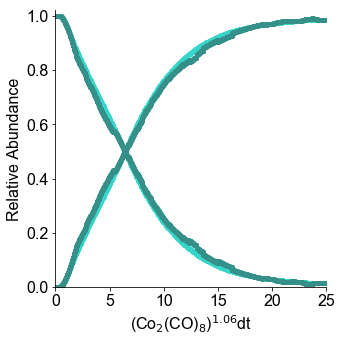

In [290]:
#generate a final plot
#good formatting starts here
palletteA = ["#003267","#12a4f1","#808fbd"]
palletteB = ["#e5de44","#ef810e","#a73232"]
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
palletteC = palletteA + palletteB
colora = ['#36d6ca','#359089']
palletteD = ["#e5de44","#fbc316","#ff9a00","#ef810e",'#005DFF','#2776FF','#4689FF','#669DFF','#7EACFF']
plt.figure(figsize=(5,5))
R_final = []
t_vtna = []
for h in range(len(xl.sheet_names)):
    for i,col in enumerate(Rzeroed[h].columns):
        if i > 0:
            t_vtna = Rzeroed[h].iloc[:,0]*float(conc[h])**order
            smoothed = Rzeroed[h][col].rolling(window[h]).mean()
            plt.plot(t_vtna, smoothed, linestyle = ':', marker='.',markersize = 8, color = colora[h])
val = []
for i in range(len(xl.sheet_names)):
    val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**order).max())
    endtime = max(val)
plt.xlim(-endtime/10, endtime)
plt.ylim(0,1.02)
plt.xlim(0,25)
plt.ylabel('Relative Abundance')
plt.xlabel('(Co$_2$(CO)$_8$)$^{{{}}}$dt'.format(str(order)))
#plt.legend([plot1,plot2],[str(conc1)+' mM', str(conc2)+ ' mM'],loc = 'best')
plt.tight_layout(True)
#plt.rc('font', size=20)
frame1 = plt.gca()
frame1.spines['top'].set_visible(False)
frame1.spines['right'].set_visible(False)
#plt.legend(frameon=False)
plt.savefig('329_vtna.png', dpi=400, filetype = 'png')

plt.show()


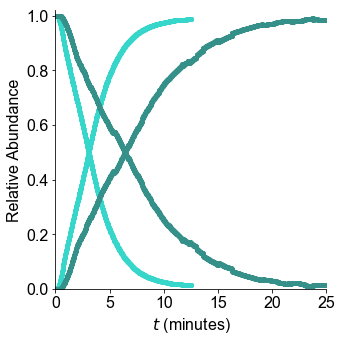

In [291]:
#original
plt.figure(figsize=(5,5))
R_final = []
t_vtna = []
for h in range(len(xl.sheet_names)):
    for i,col in enumerate(Rzeroed[h].columns):
        if i > 0:
            t_vtna = Rzeroed[h].iloc[:,0]#*float(conc[h])**order
            smoothed = Rzeroed[h][col].rolling(window[h]).mean()
            plt.plot(t_vtna, smoothed, linestyle = ':', marker='.',markersize = 8, color = colora[h], label = conc[h])
val = []
for i in range(len(xl.sheet_names)):
    val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**order).max())
    endtime = max(val)
plt.ylim(0,1.02)
plt.xlim(0,25)
#plt.xlim(-endtime/10, endtime)
plt.ylabel('Relative Abundance')
plt.xlabel('$t$ (minutes)'.format(str(order)))
#plt.legend([plot1,plot2],[str(conc1)+' mM', str(conc2)+ ' mM'],loc = 'best')
plt.tight_layout(True)
frame1 = plt.gca()
frame1.spines['top'].set_visible(False)
frame1.spines['right'].set_visible(False)
#plt.legend(frameon=False, fontsize = 12)
plt.savefig('329_overlay.png', dpi=400, filetype = 'png')

plt.show()

In [40]:
#save the new data
data_out = []
for i in range(len(xl.sheet_names)):
    #data_out.append(pd.concat([t_vtna[h],Rzeroed[h]], axis=1))
    data_out.append([t_vtna,Rzeroed])
with open("data_out.txt", 'w') as output:
    for row in data_out:
        output.write(str(row) + '\n')

In [252]:
#catalyst poisoning
#marked by suppressed activity at low concentrations
#treat by lowering the effective concentration
#function which creates interactive plot
#must know order of reaction
def interact_poisoning(Rzeroed, conc, rxn_order, window):
    conc_min = min(conc)
    def poisoned_plot(poison):
        plt.figure(figsize=(10,7))
        R_final = []
        t_vtna = []
        for h in range(len(xl.sheet_names)):
            for i,col in enumerate(Rzeroed[h].columns):
                if i > 0:
                    R_final = Rzeroed[h][col].rolling(window[h]).mean()
                    t_vtna = Rzeroed[h].iloc[:,0]*float(conc[h]-poison)**order
                    plt.plot(t_vtna, R_final, linestyle = '--', marker='.', markersize = 10)
        val = []
        for i in range(len(xl.sheet_names)):
            val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**order).max())
            endtime = max(val)
        plt.xlim(-endtime/10, endtime+endtime/10)
        #plt.title('concentration units poisoning')
        plt.ylabel('Relative Abundance')
        #three curly brackets for formatting decimale numbers as superscript
        plt.xlabel('[Catalyst-{}]$^{{{}}}$dt'.format(str(poison),str(rxn_order)))
        #plt.legend([plot1,plot2],[str(conc1)+' mM', str(conc2)+ ' mM'],loc = 'best')
        plt.rc('font', size=14)
        plt.tight_layout(True)
        plt.show()
    return interactive(poisoned_plot, 
                        poison = ipywidgets.FloatSlider(min=0., max=conc_min, step=conc_min/500., value=0.000, 
                                                           description='{} - Posion'.format(conc_min), continuous_update=False))


In [155]:
poisonedor = interact_poisoning(Rzeroed, conc, order, window)
display(poisonedor)

A Jupyter Widget

In [156]:
poison = poisonedor.children[0].value
poison

0.072

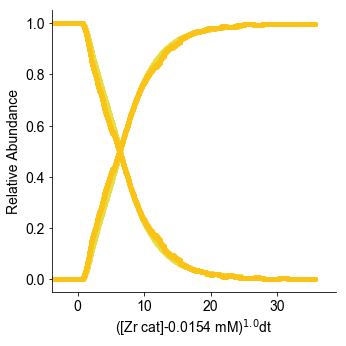

In [157]:
plt.figure(figsize=(5,5))
R_final = []
t_vtna = []
for h in range(len(xl.sheet_names)):
    for i,col in enumerate(Rzeroed[h].columns):
        if i > 0:
            t_vtna = Rzeroed[h].iloc[:,0]*float(conc[h]-poison)**order
            smoothed = Rzeroed[h][col].rolling(window[h]).mean()
            plt.plot(t_vtna, smoothed, linestyle = ':', marker ='.', markersize = 8, color = palletteD[h])
val = []
for i in range(len(xl.sheet_names)):
    val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**order).max())
    endtime = max(val)
plt.xlim(-endtime/10, endtime)
plt.ylabel('Relative Abundance')
plt.xlabel('([Zr cat]-0.0154 mM)$^{{{}}}$dt'.format(str(order)))
#plt.legend([plot1,plot2],[str(conc1)+' mM', str(conc2)+ ' mM'],loc = 'best')
plt.tight_layout(True)
#plt.rc('font', size=20)
plt.savefig('VTNA_rawplot.png', dpi=200, filetype = 'png')
frame1 = plt.gca()
frame1.spines['top'].set_visible(False)
frame1.spines['right'].set_visible(False)
#plt.legend(frameon=False)
#plt.savefig('hydroam_poisoncorrected.png', dpi=200, filetype = 'png')

plt.show()

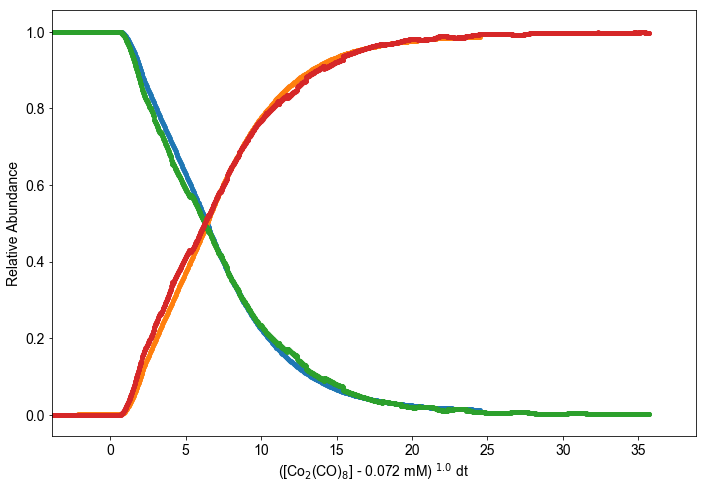

In [158]:
#generate a final plot
plt.figure(figsize=(10,7))
R_final = []
t_vtna = []
for h in range(len(xl.sheet_names)):
    for i,col in enumerate(Rzeroed[h].columns):
        if i > 0:
            R_final = Rzeroed[h][col].rolling(window[h]).mean()
            t_vtna = Rzeroed[h].iloc[:,0]*float(conc[h]-poison)**order
            plt.scatter(t_vtna, R_final, marker='.', s = 60)
val = []
for i in range(len(xl.sheet_names)):
    val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**order).max())
    endtime = max(val)
plt.xlim(-endtime/10, endtime)
plt.ylabel('Relative Abundance')
plt.xlabel('([Co$_2$(CO)$_8$] - {} mM) $^{{{}}}$ dt'.format(poison,str(order)))
#plt.legend([plot1,plot2],[str(conc1)+' mM', str(conc2)+ ' mM'],loc = 'best')
plt.tight_layout(True)
plt.rc('font', size=17)
#plt.savefig("329_vtna.png", dpi = 200)
plt.show()
